<a href="https://colab.research.google.com/github/tal-yifat/deep-NLP-explainability/blob/prediction-clustering/prediction_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
# !pip install datasets

In [2]:
# Test computational resources
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Jan  4 21:23:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   70C    P8              19W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# --- ENV & GOOGLE DRIVE SETUP ---

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/MSHA_Datasets

import pandas as pd
import numpy as np
import torch
import os

PROJECT_DIR = "prediction_clustering"
if not os.path.exists(PROJECT_DIR):
    os.makedirs(PROJECT_DIR)

# --- LOAD AND PRE-PROCESS ACCIDENT DATA ---

df = pd.read_csv("accidents.csv")
print("\nInitial shape:", df.shape)
df = df.dropna(subset=['DAYS_LOST', 'NARRATIVE'])  # remove rows missing key fields
print("After dropping NA:", df.shape)

# Replace 'EE' - a commonly used abbreviation - with 'Employee'.
df['NARRATIVE'] = df['NARRATIVE'].str.replace('(^|\s)EE', 'Employee', case=True, regex=True)

# Keep columns of interest & rename
df = df[['NARRATIVE', 'DAYS_LOST']].copy()
df.rename(columns={'NARRATIVE': 'text', 'DAYS_LOST': 'label'}, inplace=True)

# Binarize the label
TARGET_THRESHOLD = 90
df['label'] = (df['label'] > TARGET_THRESHOLD).astype(int)

# Sample 20,000 data points to do the clustering on
df = df.sample(n=20000, random_state=42)

print("\nTop 5 rows:", df.head(), "\n")

# --- CREATE & TOKENIZE DATASET (no splitting) ---

from datasets import Dataset
from transformers import AutoTokenizer

# Choose a base tokenizer matching your model
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(samples):
    return tokenizer(samples['text'], truncation=True)

dataset = Dataset.from_pandas(df)
tokenized_dataset = dataset.map(tokenize_function, batched=True)
print("Keys in tokenized_datasets:", tokenized_dataset.column_names)
print("Example of tokenized sample:", tokenized_dataset[0])

# --- LOAD TRAINED MODEL CHECKPOINT ---

trained_model_path = "deberta-v3-base_main-task-clean-version_2023-01-30-2249/deberta_injuries_model.pt"

from transformers import AutoModelForSequenceClassification, DebertaV2ForSequenceClassification
import torch

# Load the model architecture using AutoModelForSequenceClassification
# We will load a base model first and then load state dict from the local checkpoint
model_for_emb = AutoModelForSequenceClassification.from_pretrained(
    model_name,  # Load the base model architecture
    num_labels=2,
    output_hidden_states=True
)

# Load your trained weights from the local checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
model_for_emb.load_state_dict(torch.load(trained_model_path, map_location=device), strict=False)

model_for_emb.eval().to(device)

print("\nData and model loaded. `tokenized_datasets` and `model_for_emb` are ready.")

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1eOUzsDr6TjqGV_8vuLRBrBZRS5ub9uQ8/MSHA_Datasets

Initial shape: (251956, 57)
After dropping NA: (207637, 57)

Top 5 rows:                                                      text  label
137483  Company was notified thatEmployee was granted ...      0
86110   HE WAS HELPING UNLOAD REGULATOR FRAME WHEN THE...      0
96049   WHILE WORKING ON A WELDER, HE FELT HE REINJURE...      0
189742  GETTING OUT OF TRUCK--FOOT SLIPPED AND HE FELL...      0
77263   Employee reaching for handrail. He grabbed pry...      0 



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Keys in tokenized_datasets: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']
Example of tokenized sample: {'text': 'Company was notified thatEmployee was granted an award of 6.7% for permanent impairment resulting from noise-induced hearing loss.', 'label': 0, '__index_level_0__': 137483, 'input_ids': [1, 1679, 284, 8491, 272, 83030, 284, 4126, 299, 2343, 265, 525, 260, 819, 440, 270, 3747, 15015, 3500, 292, 3616, 271, 11731, 2358, 1265, 260, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-3-ad20eeaa60c2>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the

Data and model loaded. `tokenized_datasets` and `model_for_emb` are ready.


In [10]:
#############################################################
# 1. EXTRACT (768-D) EMBEDDINGS + PREDICTED PROBS FOR EACH SAMPLE
#############################################################

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
# from transformers import default_data_collator
from transformers import DataCollatorWithPadding

def extract_embeddings_and_probs(dataset, model, tokenizer, data_collator, batch_size=64):
    """
    For each sample in `dataset`, returns:
      - The final hidden state (768-dim) from the [CLS] token (or pooler output).
      - The predicted probability (model’s classification head).
    """
    dataloader = DataLoader(
        dataset.remove_columns(["label", "__index_level_0__", "text"]),  # keep only tokenized columns
        batch_size=batch_size,
        collate_fn=data_collator
    )

    all_embeddings = []
    all_probs = []
    all_labels = []  # optional: if you want ground-truth for reference
    all_texts = []   # optional: if you want to store raw text for analysis

    # We can fetch the text from the original dataset as well
    if "text" in dataset.column_names:
        text_list = dataset["text"]
    else:
        text_list = [None] * len(dataset)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    with torch.no_grad():
        idx = 0
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            # Move inputs to device
            for k in batch:
                batch[k] = batch[k].to(device)

            outputs = model(**batch, output_hidden_states=True)
            # The shape of hidden_states is (batch_size, num_layers, seq_len, hidden_size)
            # Typically, we can use the pooled output or the last hidden state [CLS] token.

            # Option 1: "pooled" approach if using model.pooler:
            #    pooled_emb = outputs.pooler_output  # shape (batch_size, 768)
            # Option 2: Use the last hidden state’s CLS token:
            last_hidden = outputs.hidden_states[-1]  # (batch_size, seq_len, 768)
            # we assume the first token is CLS in DeBERTa
            cls_emb = last_hidden[:, 0, :]  # shape (batch_size, 768)

            logits = outputs.logits  # shape (batch_size, 2)
            # Probability of class=1 (missing >=90 days)
            prob = torch.softmax(logits, dim=-1)[:, 1]

            all_embeddings.append(cls_emb.cpu().numpy())
            all_probs.append(prob.cpu().numpy())

            # If label is in batch, store
            if "labels" in batch:
                all_labels.append(batch["labels"].cpu().numpy())

            # also store text from text_list
            n = cls_emb.size(0)
            sample_texts = text_list[idx : idx+n]
            idx += n
            all_texts.extend(sample_texts)

    embeddings = np.concatenate(all_embeddings, axis=0)  # shape (N, 768)
    probs = np.concatenate(all_probs, axis=0)           # shape (N,)
    if len(all_labels) > 0:
        labels = np.concatenate(all_labels, axis=0)
    else:
        labels = None

    return embeddings, probs, labels, all_texts

import random

# Making predictions for a sample of 20k data points
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Try loading pre-computed embeddings and predictions
embeddings_path = os.path.join(PROJECT_DIR, "pred_embeddings.npy")
probs_path = os.path.join(PROJECT_DIR, "pred_probs.npy")
labels_path = os.path.join(PROJECT_DIR, "pred_labels.npy")
texts_path = os.path.join(PROJECT_DIR, "pred_texts.npy")

if os.path.exists(embeddings_path) and os.path.exists(probs_path) and \
   os.path.exists(labels_path) and os.path.exists(texts_path):

    pred_embeddings = np.load(embeddings_path)
    pred_probs = np.load(probs_path)
    pred_labels = np.load(labels_path, allow_pickle=True)
    pred_texts = np.load(texts_path, allow_pickle=True)
    print("\nLoaded pre-computed embeddings and predictions.")

else:
    print("\nGenerating embeddings and predictions...")
    pred_embeddings, pred_probs, pred_labels, pred_texts = extract_embeddings_and_probs(
        tokenized_dataset,
        model_for_emb,
        tokenizer,
        data_collator,
        batch_size=64
    )

    # Save the generated values
    np.save(embeddings_path, pred_embeddings)
    np.save(probs_path, pred_probs)
    np.save(labels_path, pred_labels, allow_pickle=True)
    np.save(texts_path, pred_texts, allow_pickle=True)
    print("\nEmbeddings and predictions generated and saved.")

print("\nEmbeddings shape:", pred_embeddings.shape)
print("Probabilities shape:", pred_probs.shape)


Loaded pre-computed embeddings and predictions.

Embeddings shape: (20000, 768)
Probabilities shape: (20000,)


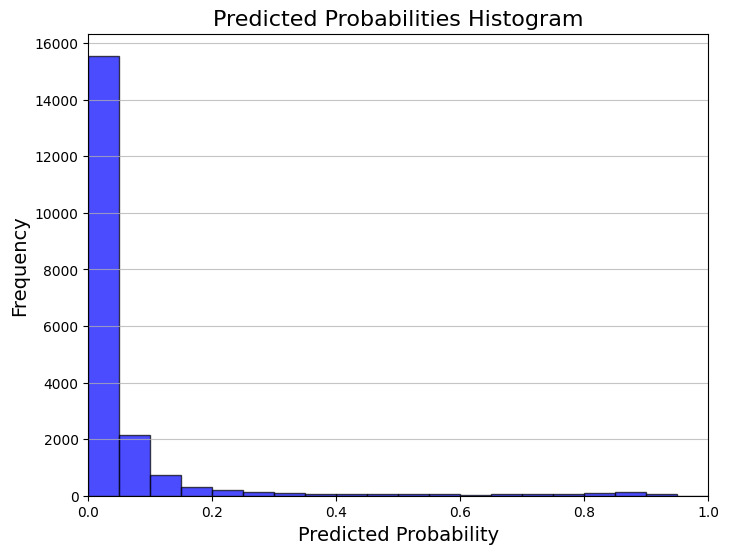


 Predicted Probability Quantile counts (bins of 5%):
0.00-0.05: 15558 (77.79%)
0.05-0.10: 2162 (10.81%)
0.10-0.15: 746 (3.73%)
0.15-0.20: 326 (1.63%)
0.20-0.25: 206 (1.03%)
0.25-0.30: 130 (0.65%)
0.30-0.35: 94 (0.47%)
0.35-0.40: 76 (0.38%)
0.40-0.45: 53 (0.27%)
0.45-0.50: 50 (0.25%)
0.50-0.55: 49 (0.24%)
0.55-0.60: 51 (0.26%)
0.60-0.65: 43 (0.21%)
0.65-0.70: 70 (0.35%)
0.70-0.75: 51 (0.26%)
0.75-0.80: 62 (0.31%)
0.80-0.85: 87 (0.43%)
0.85-0.90: 130 (0.65%)
0.90-0.95: 56 (0.28%)
0.95-1.00: 0 (0.00%)



In [7]:
import matplotlib.pyplot as plt

# Calculate quantile counts for 5% bins
quantile_counts = np.histogram(pred_probs, bins=np.linspace(0, 1, 21), density=False)[0]
total = pred_probs.size

# Create a text representation of the quantile counts
quantile_counts_text = "Predicted Probability Quantile counts (bins of 5%):\n"
for i, count in enumerate(quantile_counts):
    lower_bound = i * 0.05
    upper_bound = (i + 1) * 0.05
    quantile_counts_text += f"{lower_bound:.2f}-{upper_bound:.2f}: {count} ({count / total:.2%})\n"

# Display the histogram
plt.figure(figsize=(8, 6))  # Set the figure size
plt.hist(pred_probs, bins=np.linspace(0, 1, 21), color='blue', alpha=0.7, edgecolor='black')  # Create the histogram
plt.title("Predicted Probabilities Histogram", fontsize=16)  # Add a title
plt.xlabel("Predicted Probability", fontsize=14)  # Label for x-axis
plt.ylabel("Frequency", fontsize=14)  # Label for y-axis
plt.grid(axis='y', alpha=0.75)  # Add grid lines for y-axis
plt.xlim(0, 1)  # Set x-axis range to [0, 1]
plt.show()  # Display the plot

# Print the text representation
print("\n", quantile_counts_text)

In [13]:
################################################################
# 2. PCA (OPTIONAL) + WEIGHTING THE PREDICTED PROBABILITY
################################################################

from sklearn.decomposition import PCA
import joblib

def apply_pca_and_weight(
    embeddings_768, probs, target_prop=0.3, n_components=50
):
    """
    1) Apply PCA to the 768-d embeddings -> shape (N, n_components).
    2) Compute variance of each principal component and predicted probability.
    3) Derive alpha so that predicted_probs dimension accounts for target_prop
       fraction of total variance in the final space.
    4) Return combined array shape (N, n_components+1).
    """
    # Step A: PCA
    pca = PCA(n_components=n_components, random_state=42)
    reduced = pca.fit_transform(embeddings_768)  # shape (N, n_components)
    pc_variances = pca.explained_variance_  # length n_components

    # Sum of PCA dims variance
    sum_pc_var = np.sum(pc_variances)
    # variance of predicted probs
    pp_var = np.var(probs, ddof=1)

    # Step B: Solve for alpha
    # alpha^2 * pp_var / [sum_pc_var + alpha^2 * pp_var] = target_prop
    # => alpha = sqrt( [target_prop * sum_pc_var] / [pp_var * (1 - target_prop)] )
    # But only if target_prop < 1.0
    if target_prop >= 1.0:
        raise ValueError("target_prop must be < 1.0")
    alpha_sq = (target_prop * sum_pc_var) / (pp_var * (1 - target_prop))
    alpha = np.sqrt(alpha_sq)

    print(f"PCA dims = {n_components}, sum_pc_var = {sum_pc_var:.4f}, pp_var = {pp_var:.4f}, alpha = {alpha:.4f}")

    # Weighted prob
    w_probs = alpha * probs.reshape(-1, 1)

    # Combine
    X_final = np.hstack([reduced, w_probs])
    return X_final, pca, alpha


# Reduce data dimensionality
embeddings_768 = pred_embeddings
probs_array = pred_probs
target_prop = 0.3
n_components = 50

X_pca, pca_model, alpha = apply_pca_and_weight(
    embeddings_768, probs_array, target_prop=target_prop, n_components=n_components
)

print("Final shape after PCA+prob weighting:", X_pca.shape)

PCA dims = 50, sum_pc_var = 383.9771, pp_var = 0.0193, alpha = 92.2315
Final shape after PCA+prob weighting: (20000, 51)


In [21]:
################################################################
# 3.a K-MEANS CLUSTERING AND CHOOSING K for the PCAed dataset
################################################################

import os
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

EXPERIMENT_RESULTS_PATH = os.path.join(PROJECT_DIR, "kmeans_experiment_results_pca.pkl")
BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "kmeans_best_model_pca.pkl")

def find_optimal_k(X, k_min=4, k_max=12):
    best_k = None
    best_score = -1
    results = {}

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        results[k] = sil
        print(f"K={k}, Silhouette={sil:.4f}")
        if sil > best_score:
            best_score = sil
            best_k = k

    print(f"Best K={best_k} with silhouette={best_score:.4f}")
    return best_k, best_score, results

# Check if results already exist
if os.path.exists(EXPERIMENT_RESULTS_PATH) and os.path.exists(BEST_MODEL_PATH):
    print("Loading results and model from disk...")
    experiment_data = joblib.load(EXPERIMENT_RESULTS_PATH)
    best_k = experiment_data["best_k"]
    silhouette_scores = experiment_data["silhouette_scores"]
    kmeans = joblib.load(BEST_MODEL_PATH)
    print(f"Loaded best K={best_k}")
    print(f"Silhouette scores: {silhouette_scores}")
else:
    print("Running experiment to find optimal K...")
    k_min, k_max = 5, 15
    best_k, best_score, silhouette_scores = find_optimal_k(X_pca, k_min, k_max)

    # Save results
    experiment_data = {
        "best_k": best_k,
        "best_score": best_score,
        "silhouette_scores": silhouette_scores,
    }
    joblib.dump(experiment_data, EXPERIMENT_RESULTS_PATH)

    # Train final KMeans with best_k and save
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit(X_pca)
    joblib.dump(kmeans, BEST_MODEL_PATH)

    print("Experiment results and best model saved.")

# Final cluster labels
labels = kmeans.labels_
print("Final cluster labels shape:", labels.shape)

Loading results and model from disk...
Loaded best K=6
Silhouette scores: {5: 0.49205995, 6: 0.49415395, 7: 0.4648985, 8: 0.4580418, 9: 0.43600133, 10: 0.42271915, 11: 0.40604848, 12: 0.38853607, 13: 0.37481418, 14: 0.3567668, 15: 0.35078707}
Final cluster labels shape: (20000,)


In [ ]:
################################################################
# 3.b K-MEANS CLUSTERING AND CHOOSING K for the full dimensioned dataset
################################################################

EXPERIMENT_RESULTS_PATH = os.path.join(PROJECT_DIR, "kmeans_experiment_results_768.pkl")
BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "kmeans_best_model_768.pkl")

# Check if results already exist
if os.path.exists(EXPERIMENT_RESULTS_PATH) and os.path.exists(BEST_MODEL_PATH):
    print("Loading results and model from disk...")
    experiment_data = joblib.load(EXPERIMENT_RESULTS_PATH)
    best_k = experiment_data["best_k"]
    silhouette_scores = experiment_data["silhouette_scores"]
    kmeans = joblib.load(BEST_MODEL_PATH)
    print(f"Loaded best K={best_k}")
    print(f"Silhouette scores: {silhouette_scores}")
else:
    print("Running experiment to find optimal K...")
    k_min, k_max = 5, 15
    best_k, best_score, silhouette_scores = find_optimal_k(X_pca, k_min, k_max)

    # Save results
    experiment_data = {
        "best_k": best_k,
        "best_score": best_score,
        "silhouette_scores": silhouette_scores,
    }
    joblib.dump(experiment_data, EXPERIMENT_RESULTS_PATH)

    # Train final KMeans with best_k and save
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit(X_pca)
    joblib.dump(kmeans, BEST_MODEL_PATH)

    print("Experiment results and best model saved.")

# Final cluster labels
labels = kmeans.labels_
print("Final cluster labels shape:", labels.shape)

In [ ]:
################################################################
# 4. INSPECTION OF CLUSTERS
################################################################

import pandas as pd
import numpy as np

df_clusters = pd.DataFrame({
    "cluster": labels,
    "prob": probs_array,
    "text": test_texts
})

# We can sample from each cluster for inspection:
def sample_points_for_cluster(dfc, cluster_id, top_n_centroid=5, random_n=10):
    """
    top_n_centroid: pick N points closest to cluster centroid
    random_n: pick random points from the cluster
    """
    cluster_df = dfc[dfc["cluster"] == cluster_id].copy()
    # Indices in X_final that belong to this cluster
    indices = cluster_df.index.values

    # compute distances to centroid
    centroid = kmeans.cluster_centers_[cluster_id]  # shape (d_reduced+1,)
    points = X_final[indices]
    dists = np.linalg.norm(points - centroid, axis=1)
    cluster_df["dist2centroid"] = dists

    # sort by distance ascending
    cluster_df_sorted = cluster_df.sort_values("dist2centroid")
    top_centroid = cluster_df_sorted.head(top_n_centroid)
    # random picks
    random_picks = cluster_df_sorted.sample(n=min(random_n, len(cluster_df_sorted)), random_state=42)

    return top_centroid, random_picks

# Example: Inspect cluster 0
c0_centroid, c0_random = sample_points_for_cluster(df_clusters, 0, 5, 10)
print("Cluster 0 - Top 5 near centroid\n", c0_centroid[["prob", "dist2centroid", "text"]])
print("\nCluster 0 - 10 random picks\n", c0_random[["prob", "dist2centroid", "text"]])